In [1]:
from utils.mnist import MNIST, MNIST_NORMALIZATION
from utils.emnist import EMNIST
from utils.fmnist import FashionMNIST
from core.cnn import simple_cnn
from core.maha import maha_distance
from torchvision import datasets,transforms
import torch
import numpy as np
from utils.score import plot
import matplotlib.pyplot as plt

In [2]:
tf = transforms.Compose([
            transforms.ToTensor(),
            MNIST_NORMALIZATION,
        ])
train_data = MNIST('./dataset/',download=True,mode = 'all',transform=tf)
test_id = MNIST('./dataset/', download=True,mode = 'all',transform=tf,train=False)
test_near_ood = EMNIST('./dataset/',download=True,transform=tf,train=False,split='letters')
test_far_ood = FashionMNIST('./dataset/',download=True,transform=tf,train=False)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = 128,shuffle=True)
test_id_loader = torch.utils.data.DataLoader(test_id,batch_size = 128,shuffle=True)
test_near_ood_loader = torch.utils.data.DataLoader(test_near_ood,batch_size = 128,shuffle=True)
test_far_ood_loader = torch.utils.data.DataLoader(test_far_ood,batch_size = 128,shuffle=True)

In [10]:
model = simple_cnn(y_dim = 10,DROPOUT=True).to('cuda:0')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-4)


### Training

In [11]:
for e in range(5):
    for image,label in train_loader:
        out = model(image.to('cuda'))
        # print(out.shape,label)
        loss = criterion(out,label.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)

tensor(0.0195, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0776, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1148, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0466, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0316, device='cuda:0', grad_fn=<NllLossBackward>)


### Test Accuracy

In [17]:
y_true = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out = model(image.to('cuda'))
        out = torch.softmax(out,-1)
        a,pred_logit = torch.max(out,dim=-1)
        y_true += (label==pred_logit.cpu()).numpy().tolist()
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))

Accuracy:0.9839


### Uncertainty

In [39]:
model.train()

total=10

prob = torch.zeros(total,test_id.__len__(),10).to('cuda')

with torch.no_grad():
    n_total = 0     
    for image,label in test_id_loader:
        for T in range(total):
            # Foraward path
            model_pred    = model.forward(image.to('cuda'))
            model_pred = torch.softmax(model_pred,dim=-1)
            prob[T,n_total:n_total+image.size(0),:]=model_pred
        n_total     += image.size(0)
mean = torch.mean(prob,dim=0) # [N x D]
var = torch.mean(torch.square(prob+1e-6),dim=0)-torch.square(mean+1e-6) # [N x D]
id_score = torch.mean(torch.sqrt(var+1e-6),dim=-1) # [N]
id_score = id_score.cpu().numpy()
print(np.mean(id_score))

prob = torch.zeros(total,test_near_ood.__len__(),10).to('cuda')

with torch.no_grad(): 
    n_total = 0  
    for image,label in test_near_ood_loader:
        for T in range(total):
            # Foraward path
            model_pred    = model.forward(image.to('cuda'))
            model_pred = torch.softmax(model_pred,dim=-1)
            prob[T,n_total:n_total+image.size(0),:]=model_pred
        n_total     += image.size(0)

mean = torch.mean(prob,dim=0) # [N x D]
var = torch.mean(torch.square(prob+1e-6),dim=0)-torch.square(mean+1e-6) # [N x D]
near_ood_score = torch.mean(torch.sqrt(var+1e-6),dim=-1) # [N]
near_ood_score = near_ood_score.cpu().numpy()
print(np.mean(near_ood_score))

prob = torch.zeros(total,test_far_ood.__len__(),10).to('cuda')

with torch.no_grad():
    n_total = 0        
    for image,label in test_far_ood_loader:
        for T in range(total):
            # Foraward path
            model_pred    = model.forward(image.to('cuda'))
            model_pred = torch.softmax(model_pred,dim=-1)
            prob[T,n_total:n_total+image.size(0),:]=model_pred
        n_total     += image.size(0)

mean = torch.mean(prob,dim=0) # [N x D]
var = torch.mean(torch.square(prob+1e-6),dim=0)-torch.square(mean+1e-6) # [N x D]
far_ood_score = torch.mean(torch.sqrt(var+1e-6),dim=-1) # [N]
far_ood_score = far_ood_score.cpu().numpy()
print(np.mean(far_ood_score))


0.004785434
0.044689823
0.05115143


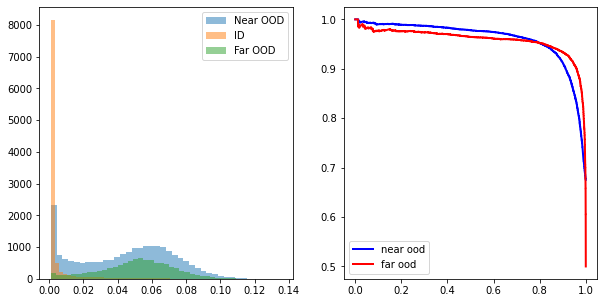

Near AUROC:0.9278722307692308, Far AUROC: 0.9701978150000001


In [40]:
auroc = plot(id_score,near_ood_score,far_ood_score,name='Droout',
                        reverse=True)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))